In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from clustering import *
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
import umap
import hdbscan

/Users/admin/anaconda3/envs/patent_project/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load the pre-computed cleaned datasets depending on how much data we want to work on.

In [2]:
data_small = "data/small_df/cleaned_small.csv"
data_avg = "data/average_df/cleaned_avg.csv"
data_tot = "data/total_df/cleaned_tot.csv"

df = pd.read_csv(data_tot)

## Data Preprocessing

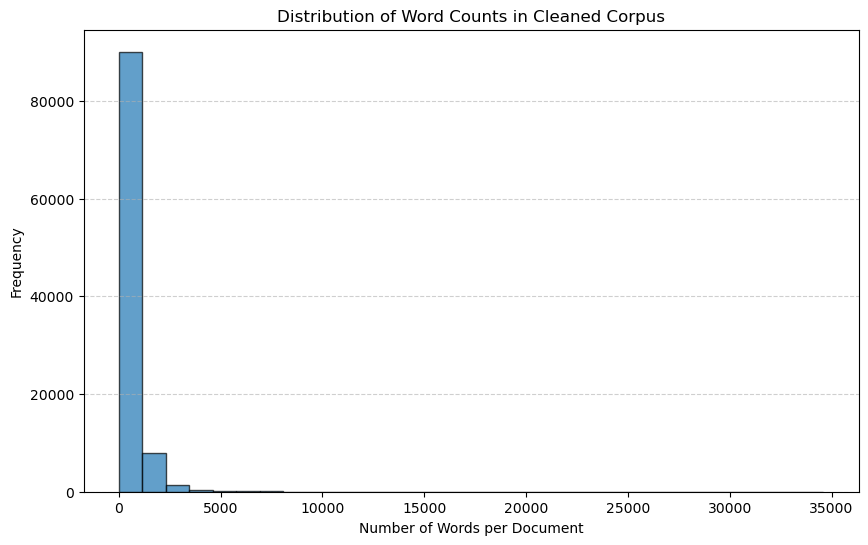

630.6435535644644

In [3]:
count_df = df.copy()
count_df["word_count"] = count_df["cleaned_corpus"].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10, 6))
plt.hist(count_df["word_count"], bins=30, edgecolor="black", alpha=0.7)
plt.xlabel("Number of Words per Document")
plt.ylabel("Frequency")
plt.title("Distribution of Word Counts in Cleaned Corpus")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()
count_df["word_count"].mean()

There is only one document with more than 10 000 words, would this impact our work ? 

## TF-IDF

TF-IDF matrix is the matrix of the tf-idf scores of the words (columns) for each document (rows).

**Term frequency** (TF) looks at the frequency of a particular term relative to the document. For example, raw count of the number of times the word appears in the document. 

**Inverse document frequency** focuses of how common a word is amongst the corpus of document.

**Computation of TF-IDF vector:**
$$
tfidf(t,d,D) = tf(t,d)*idf(t,D)
$$

with t being the word we which to compute the commonness of within the corpus d of the set of corpuses D. 

BE CAREFUL : with Sklearn, the idf score is 1 if a word appears in all the documents. 

In [4]:
corpus = df["cleaned_corpus"].dropna().tolist()

custom_stopwords = {
    "shaft", "plate", "member", "frame", "lever", "arm", "bar",
    "valve", "spring", "wheel", "machine", "rod", "pipe",
    "cylinder", "tube", "casing", "chamber", "head", "body"
}

#### How many words appear in all the documents ? 

In [5]:
vectorizer_tf_idf = TfidfVectorizer(stop_words="english", max_features=10000)
X_tfidf = vectorizer_tf_idf.fit_transform(corpus)

TF-IDF score moyen : 71.57433579309243


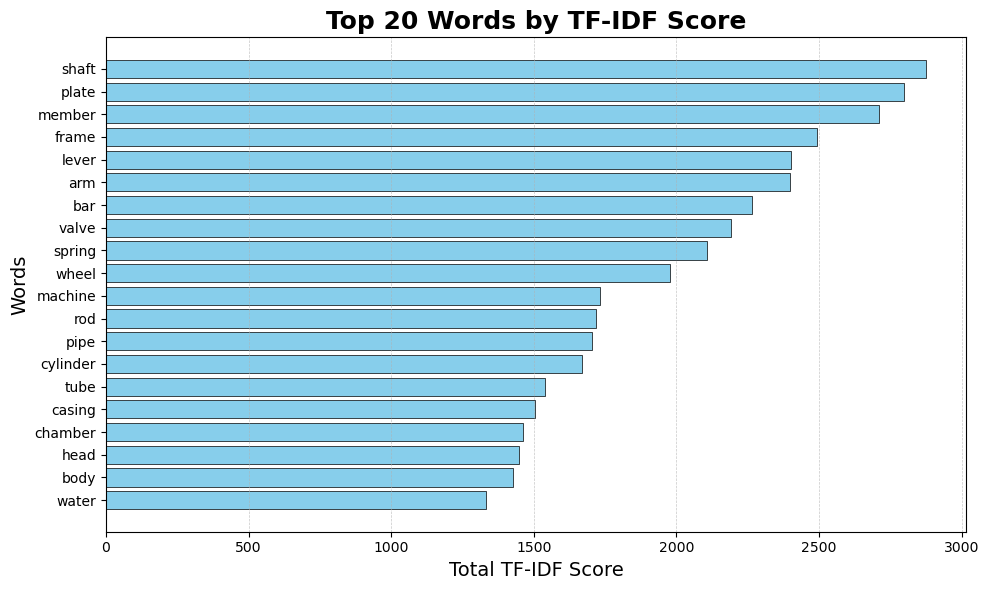

In [6]:
# Get the words and their summed tf-idf scores (accross all docs)
feature_names = vectorizer_tf_idf.get_feature_names_out()
word_importance = np.array(X_tfidf.sum(axis=0)).flatten()

df_tfidf = pd.DataFrame({"word": feature_names, "tfidf_sum": word_importance})
df_tfidf = df_tfidf.sort_values(by="tfidf_sum", ascending=False)

tfidf_mean = df_tfidf["tfidf_sum"].mean()
print("TF-IDF score moyen :", tfidf_mean)

# Plot the 20 words with the highest tf-idf scores
df_top_words = df_tfidf.head(20)

df_top_words_sorted = df_top_words.sort_values(by="tfidf_sum", ascending=False)

plt.figure(figsize=(10, 6))
bars = plt.barh(df_top_words_sorted["word"], df_top_words_sorted["tfidf_sum"],
                color="skyblue", edgecolor="black", linewidth=0.5)

plt.xlabel("Total TF-IDF Score", fontsize=14)
plt.ylabel("Words", fontsize=14)
plt.title("Top 20 Words by TF-IDF Score", fontsize=18, fontweight="bold")
plt.gca().invert_yaxis() 
plt.grid(axis='x', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

"shaft", "plate", "member", "frame", "lever", "arm", "bar", "valve", "spring", "wheel", "machine", "rod", "pipe", "cylinder", "tube", "casing", "chamber", "head", "body"

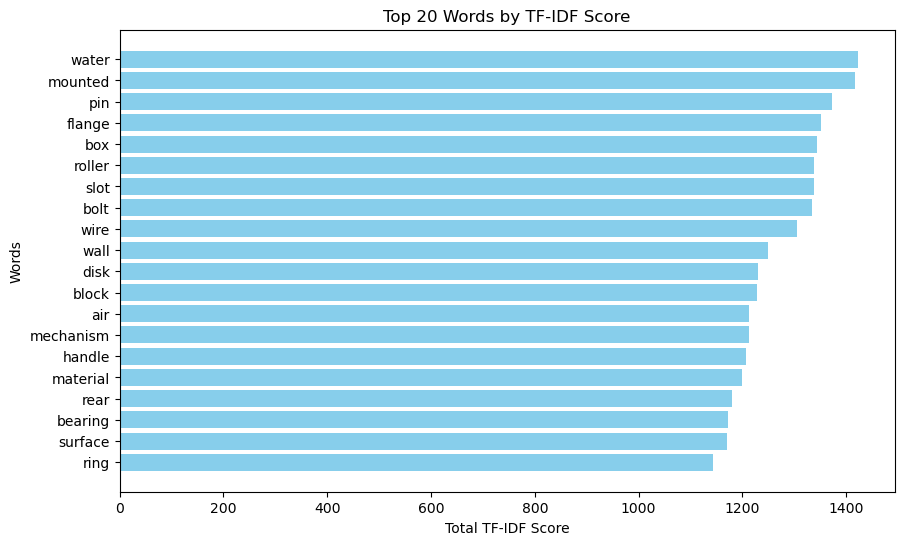

In [7]:
# Lowercase all stopwords for consistency
custom_stopwords = [word.lower() for word in custom_stopwords]

corpus_cleaned = [delete_stopwords(text, custom_stopwords) for text in corpus]

vectorizer_tf_idf = TfidfVectorizer(stop_words="english", max_features=10000)
X_tfidf = vectorizer_tf_idf.fit_transform(corpus_cleaned)

# Get the words and their summed tf-idf scores (accross all docs)
feature_names = vectorizer_tf_idf.get_feature_names_out()
word_importance = np.array(X_tfidf.sum(axis=0)).flatten()

df_tfidf = pd.DataFrame({"word": feature_names, "tfidf_sum": word_importance})
df_tfidf = df_tfidf.sort_values(by="tfidf_sum", ascending=False)

# Plot the 20 words with the highest tf-idf scores
df_top_words = df_tfidf.head(20)

plt.figure(figsize=(10, 6))
plt.barh(df_top_words["word"], df_top_words["tfidf_sum"], color="skyblue")
plt.xlabel("Total TF-IDF Score")
plt.ylabel("Words")
plt.title(f"Top {20} Words by TF-IDF Score")
plt.gca().invert_yaxis()  
plt.show()

## K-Means Clustering

### Number of clusters: Elbow Method

This method involves finding the optimal K via graphical representation. It finds the within cluster sum of squares (WCSS), i.e. the sum of the square distance between points in a cluster and the cluster centroid. 

If the plotting of the WCSS over the number of clusters represents an elbow, then we pick the K-value where the elbow gets created. Beyond the elbow point, increasing the value of 'K' does not lead to a significant reduction in WCSS. 

Here we test for k from 2 to 15. 

In [8]:
#elbow_scores = elbow_method(X_tfidf, 50)

Adding more data, the elbow becomes more and more clear. Here we could consider K=37.

### Number of clusters: Silhouette Method

The value of the Silhouette score ranges from -1 to 1:

- 1: Points are perfectly assigned in a cluster and clusters are easily distinguishable.
- 0: Clusters are overlapping.
- -1: Points are wrongly assigned in a cluster.

It is computed as follows:
$$
Silhouette Score = \frac{b-a}{max(a, b)}
$$

- a is the average <ins>intra-cluster</ins> distance, i.e the average distance between each point within a cluster.
- b is the average <ins>inter-cluster</ins> distance i.e the average distance between all clusters.


In [9]:
#optimal_k, silhouette_scores = compute_silhouette_method(X_tfidf, 50)

It seems the silhouette method confirms K = 37 too. 

### K-Means

Based on the previous results, we compute K-Means with K = 37. 

We can see from the results that the clusters are not visually clear, and one of them contains a large amount of data. Would be important to also verify wether the smaller ones contain the outliers in terms of number of words within the corpus. 

K-Means converged in 93 iterations.


/Users/admin/anaconda3/envs/patent_project/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


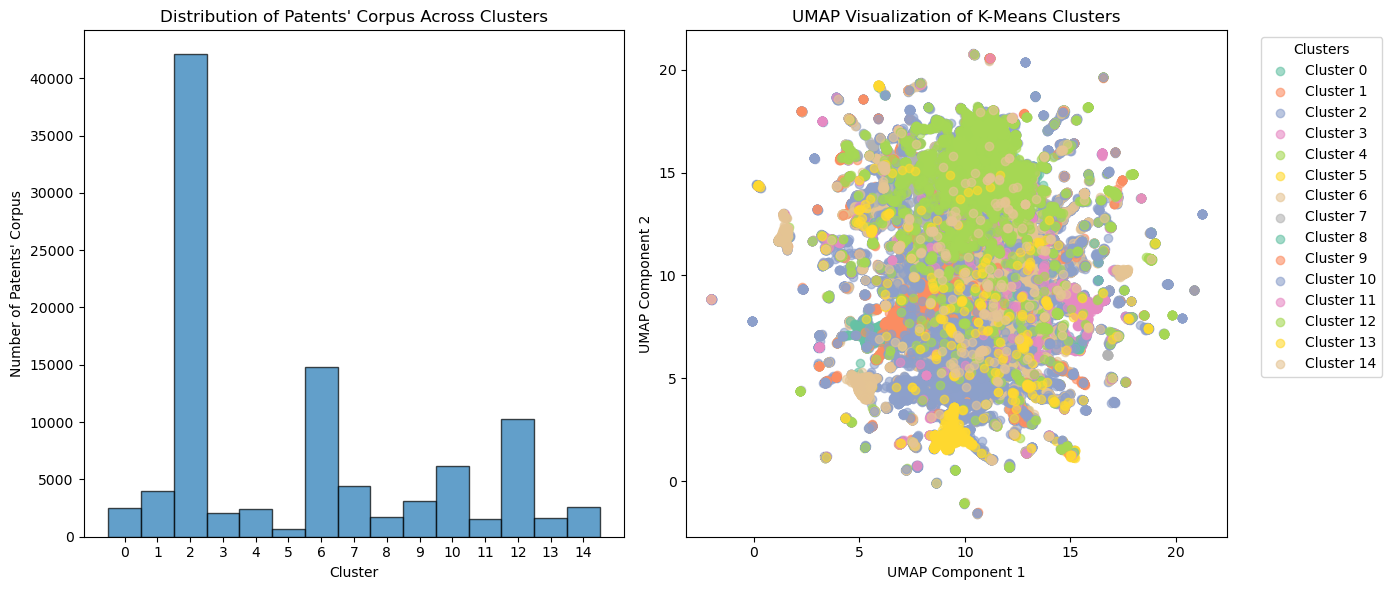

<Figure size 640x480 with 0 Axes>

Cluster 0: piston, port, engine, steam, exhaust, pressure, pump, air, passage, fluid
Cluster 1: circuit, switch, armature, current, magnet, contact, coil, motor, conductor, electric
Cluster 2: box, bolt, flange, slot, cover, strip, wall, handle, piece, pin
Cluster 3: car, drawhead, coupling, link, track, truck, brake, platform, coupler, pin
Cluster 4: axle, vehicle, rear, hub, plow, bearing, box, forward, beam, truck
Cluster 5: gate, post, latch, hinge, open, closed, pivoted, rail, gatepost, weight
Cluster 6: roller, gear, mechanism, roll, disk, mounted, pulley, carriage, spindle, cam
Cluster 7: process, acid, solution, compound, composition, water, electrode, material, mixture, temperature
Cluster 8: jaw, wrench, handle, shank, movable, screw, tool, pivoted, clamp, teeth
Cluster 9: blade, cutter, knife, cutting, handle, cut, tool, shank, slot, screw
Cluster 10: wire, hook, shoe, loop, strap, heel, buckle, eye, bent, shank
Cluster 11: door, car, latch, bolt, closed, hinge, lock, open, 

In [10]:
df_clusters, cluster_keywords = k_means(X_tfidf, 15, df, False, vectorizer_tf_idf)

### Variations: K-Means ++
Instead of picking the centroids randomly, K-Means++ picks the first centroid randomly, and then it selects each next centroid probabilistically (higher probability to points that are farther away from already chosen centroids).

This ensures a good spread of initial centroids, reducing the chances of poor local minima.

K-Means converged in 109 iterations.


/Users/admin/anaconda3/envs/patent_project/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


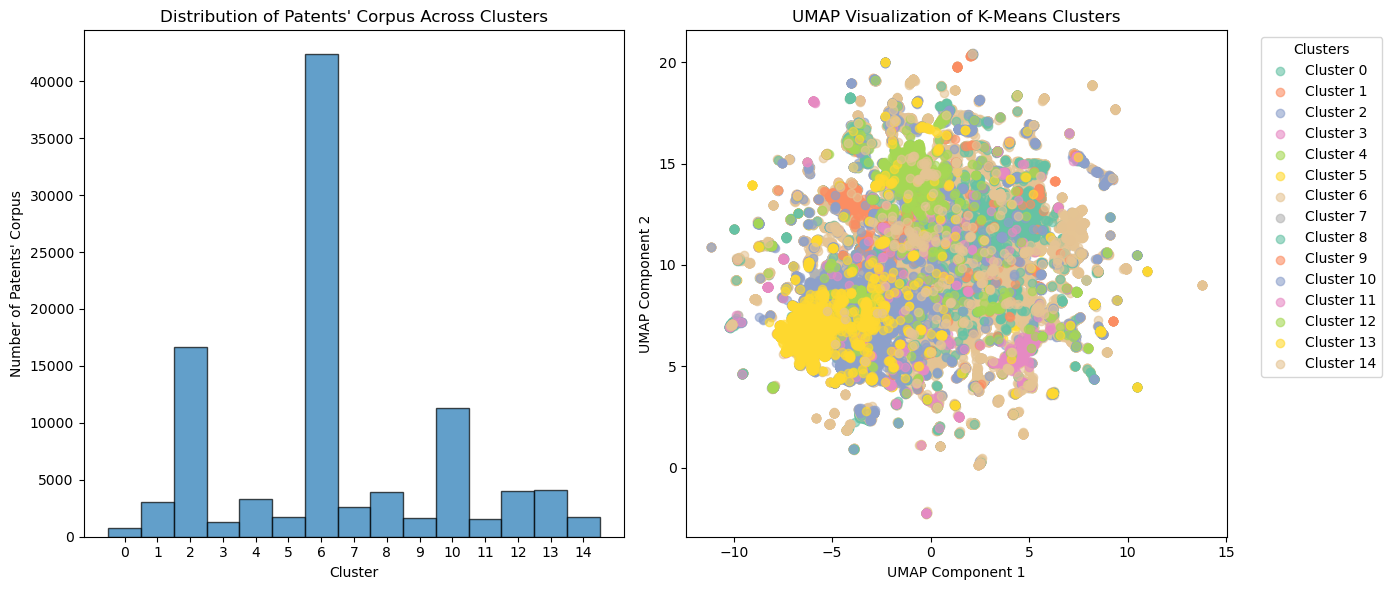

<Figure size 640x480 with 0 Axes>

Cluster 0: bottle, stopper, neck, cap, cork, liquid, mouth, disk, content, nonrefillable
Cluster 1: blade, cutter, knife, cutting, handle, cut, tool, shank, screw, slot
Cluster 2: gear, axle, mechanism, mounted, disk, spindle, pulley, carriage, bearing, sleeve
Cluster 3: tire, rim, spoke, felly, hub, tread, ring, flange, pneumatic, vehicle
Cluster 4: roller, roll, paper, bearing, mounted, sheet, belt, box, surface, strip
Cluster 5: jaw, wrench, handle, shank, movable, screw, tool, pivoted, clamp, face
Cluster 6: box, flange, bolt, strip, slot, piece, cover, wall, metal, pin
Cluster 7: piston, port, engine, steam, exhaust, pressure, air, pump, passage, fluid
Cluster 8: wire, hook, gate, post, loop, fence, eye, bent, link, pin
Cluster 9: beam, plow, cultivator, standard, rear, moldboard, axle, bolt, shovel, share
Cluster 10: water, tank, vessel, air, liquid, steam, acid, process, apparatus, solution
Cluster 11: door, car, latch, bolt, closed, hinge, lock, open, hinged, locking
Cluster 12

In [11]:
df_clusters, cluster_keywords = k_means(X_tfidf, 15, df, True, vectorizer=vectorizer_tf_idf)

In [12]:
# Saves mapping patent to clusters in CSV file
df_clusters["Keywords"] = df_clusters["Cluster"].map(cluster_keywords)
df_clusters[["patent_id", "Cluster", "Keywords","DistanceToCentroid"]].sort_values(by=["Cluster", "DistanceToCentroid"], ascending=[True, False]).to_csv("data/clusters_tf_idf.csv", index=False)

## UMAP

UMAP can be used as an effective preprocessing step to boost the performance of density based clustering.

Potential issues with using dimensionality reduction as clustering input : https://stats.stackexchange.com/questions/263539/clustering-on-the-output-of-t-sne

Potential issues :
- UMAP does not completely preserve density (issue for density based clustering : HDBSCAN ?). 
- UMAP can also create false tears in clusters, resulting in a finer clustering than is necessarily present in the data.

**Arguments**

- Small values in **n_neighbors** will focus more on very local structure and are more prone to producing fine grained cluster structure that may be more a result of patterns of noise in the data than actual clusters.
- Set **min_dist** to a very low value, since we actually want to pack points together densely. This parameter controls how tightly UMAP clumps points together, with low values leading to more tightly packed embeddings.


In [13]:
X_umap = umap.UMAP(n_neighbors = 30, min_dist = 0.0, n_components = 2, random_state=42).fit_transform(X_tfidf)
plt.scatter(X_umap[:, 0], X_umap[:, 1], s=0.1, cmap='Spectral')

/Users/admin/anaconda3/envs/patent_project/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/admin/anaconda3/envs/patent_project/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


KeyboardInterrupt: 

### UMAP and K-Means++

K-Means converged in 21 iterations.


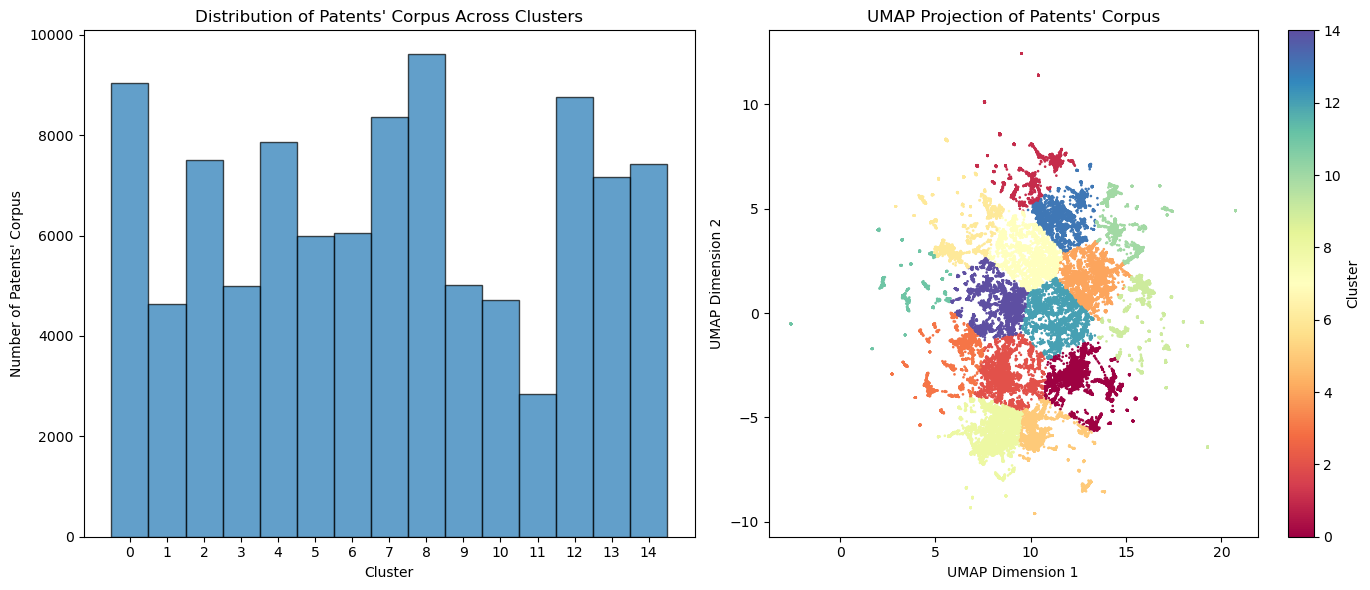

In [ ]:
df_clusters_umap = k_means(X_umap, 15, df, True)

### UMAP and HDBSCAN

The concept of this algorithm is that it groups points that are closely packed together while marking points in low-density regions as noise. Then, it builds a minimum spanning tree (MST) of the data points, where the edges represent distances.

This MST is then used to construct a hierarchy of clusters by progressively removing the longer edges. This produces a hierarchical tree of clusters instead of a single clustering solution. 

It then transforms the hierarchical tree into a condensed tree, where each cluster is assigned a "stability" score, which is determined by how persistent a cluster remains at different levels of the hierarchy. Finally, it automatically selects the most stable clusters, leading to a more robust clustering solution.

/Users/admin/anaconda3/envs/patent_project/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/admin/anaconda3/envs/patent_project/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


There are 23 different clusters.
There are 34559 unclassified patents.


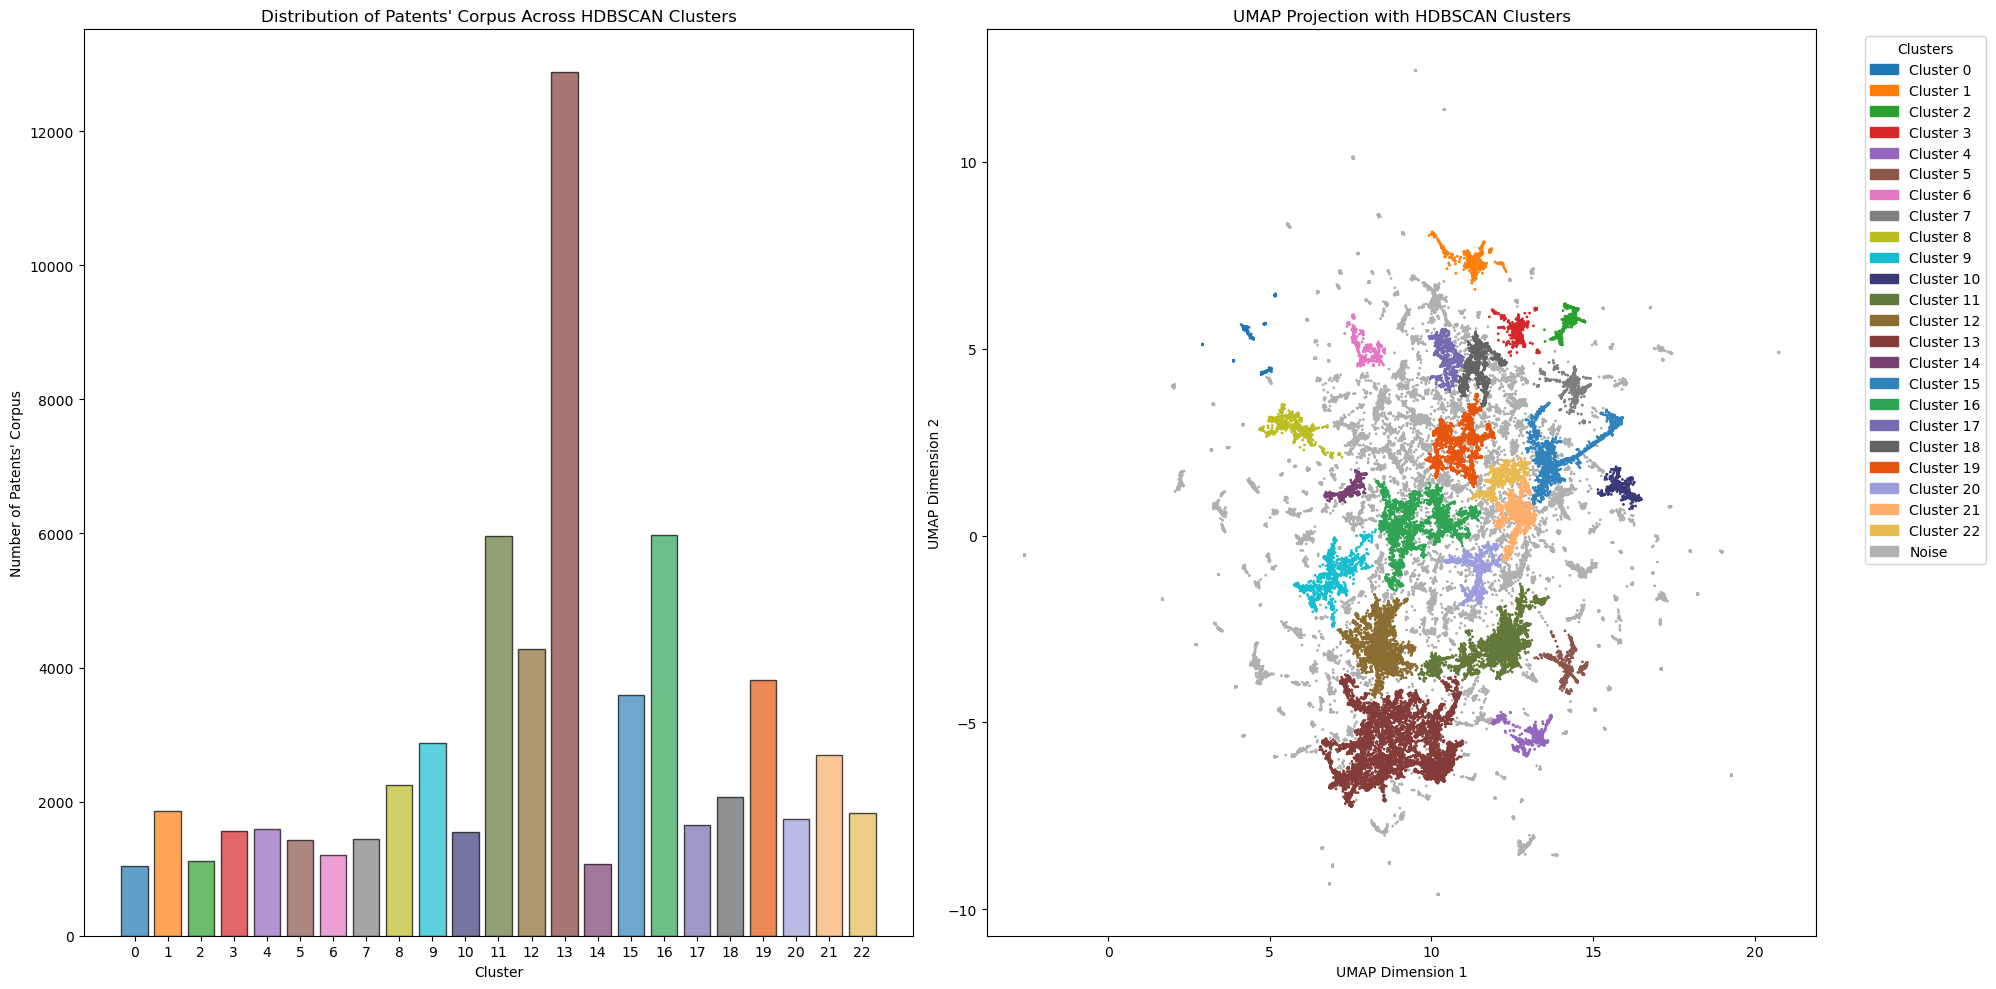

In [ ]:
import matplotlib.patches as mpatches

np.random.seed(42)

# HDBSCAN clustering on the UMAP data
clusterer = hdbscan.HDBSCAN(min_cluster_size=1000, min_samples=1) #cluster_selection_epsilon=0.1)
labels_hdbscan = clusterer.fit_predict(X_umap)

df_clusters_hdbscan = pd.DataFrame({
        "patent_id": df["patent_id"],
        "Cluster": labels_hdbscan
    })

num_clusters = len(set(labels_hdbscan)) - (1 if -1 in labels_hdbscan else 0)
print(f"There are {num_clusters} different clusters.")

invalid_points = labels_hdbscan[labels_hdbscan == -1]
print(f"There are {len(invalid_points)} unclassified patents.")

# Define a list of 30 distinct hex color codes
distinct_colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
    "#393b79", "#637939", "#8c6d31", "#843c39", "#7b4173",
    "#3182bd", "#31a354", "#756bb1", "#636363", "#e6550d",
    "#9c9ede", "#fdae6b", "#e7ba52", "#ad494a", "#a55194",
    "#de9ed6", "#9edae5", "#ff1493", "#f7b6d2", "#c5b0d5"
]

# Create a mapping from cluster label to a distinct color.
# We'll use the first N colors from distinct_colors, where N is the number of unique valid clusters.
valid_labels = labels_hdbscan[labels_hdbscan != -1]
unique_clusters = np.sort(np.unique(valid_labels))
n_unique = len(unique_clusters)

# Ensure we have enough colors; if not, cycle through the list
if n_unique > len(distinct_colors):
    raise ValueError("Not enough distinct colors defined for the number of clusters.")

color_map = {cluster: distinct_colors[i] for i, cluster in enumerate(unique_clusters)}

# Define a color for noise points (if any)
noise_color = "#B0B0B0"  # light gray

# Map each point's label to its corresponding color
point_colors = np.array([color_map[label] if label != -1 else noise_color for label in labels_hdbscan])

# Prepare the figure
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Visualizing the distribution of clusters with matching bar colors
if len(valid_labels) > 0:
    # Count the number of occurrences for each valid cluster
    cluster_counts = pd.Series(valid_labels).value_counts().sort_index()
    bar_colors = [color_map[label] for label in cluster_counts.index]
    axes[0].bar(cluster_counts.index.astype(str), cluster_counts.values,
                color=bar_colors, edgecolor='black', alpha=0.7)
    axes[0].set_xlabel("Cluster")
    axes[0].set_ylabel("Number of Patents' Corpus")
    axes[0].set_title("Distribution of Patents' Corpus Across HDBSCAN Clusters")
else:
    axes[0].text(0.5, 0.5, 'No valid clusters',
                 horizontalalignment='center', verticalalignment='center')

# Visualizing the clusters using UMAP projection
scatter = axes[1].scatter(X_umap[:, 0], X_umap[:, 1], c=point_colors, s=1)
axes[1].set_title("UMAP Projection with HDBSCAN Clusters")
axes[1].set_xlabel("UMAP Dimension 1")
axes[1].set_ylabel("UMAP Dimension 2")

# Create a custom legend
legend_handles = []
for cluster in unique_clusters:
    patch = mpatches.Patch(color=color_map[cluster], label=f"Cluster {cluster}")
    legend_handles.append(patch)
# Add a handle for noise if any (-1)
if -1 in labels_hdbscan:
    legend_handles.append(mpatches.Patch(color=noise_color, label="Noise"))
axes[1].legend(handles=legend_handles, title="Clusters", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()

In [ ]:
def top_words_for_patent(X_tfidf, index, vectorizer, top_n=10):
    row = X_tfidf[index]
    feature_names = np.array(vectorizer.get_feature_names_out())
    row_data = row.toarray().flatten()
    top_indices = row_data.argsort()[-top_n:][::-1]
    return feature_names[top_indices]

##### Ranking by Membership Strength to the Cluster

In each cluster, which patents are the most important ? The ones that "match" the cluster the most ? 

To respond, I first use the probabilities_ attribute of HDBSCAN, which computes a membership strength for each point (between 0 and 1), representing how strongly the point belongs to its cluster.

In [ ]:
def rank_patents_by_membership_strength(df, labels, probabilities, X_tfidf, vectorizer):
    df_copy = df.copy()
    df_copy["Cluster"] = labels
    df_copy["MembershipStrength"] = probabilities

    # Add top words per patent
    top_words_all = []
    for idx in df_copy.index:
        if df_copy.loc[idx, "Cluster"] == -1:
            top_words_all.append("") 
        else:
            top_words = top_words_for_patent(X_tfidf, idx, vectorizer)
            top_words_all.append(", ".join(top_words))
    
    df_copy["TopWords"] = top_words_all

    return df_copy

In [ ]:
ranked_by_strength_df = rank_patents_by_membership_strength(df, labels_hdbscan, clusterer.probabilities_, X_tfidf, vectorizer_tf_idf)
ranked_by_strength_df = ranked_by_strength_df[["patent_id", "Cluster", "MembershipStrength", "TopWords"]].sort_values(by=["Cluster", "MembershipStrength"], ascending=[True, False])

for cluster_id in ranked_by_strength_df["Cluster"].unique():
    cluster_df = ranked_by_strength_df[ranked_by_strength_df["Cluster"] == cluster_id].head(5)

    print(f"\nCluster {cluster_id}")
    for _, row in cluster_df.iterrows():
        print(f"\nPatent ID: {row['patent_id']}")
        print(f"Membership Strength: {row['MembershipStrength']:.4f}")
        print(f"Top Words: {row['TopWords']}")

ranked_by_strength_df.to_csv("data/membership_hdbscan_tf.csv", index = False)


Cluster -1

Patent ID: 709987
Membership Strength: 0.0000
Top Words: 

Patent ID: 858653
Membership Strength: 0.0000
Top Words: 

Patent ID: 57356
Membership Strength: 0.0000
Top Words: 

Patent ID: 153178
Membership Strength: 0.0000
Top Words: 

Patent ID: 323433
Membership Strength: 0.0000
Top Words: 

Cluster 0

Patent ID: 439142
Membership Strength: 1.0000
Top Words: hoop, platen, chine, ring, barrel, bearingsurface, memphis, flange, shrinkage, groove

Patent ID: 188218
Membership Strength: 1.0000
Top Words: gate, eyebolts, hinge, bolt, gatepost, fastened, ratchetteeth, sliding, raised, post

Patent ID: 357615
Membership Strength: 1.0000
Top Words: breastplate, stave, knife, slot, curved, jointing, concave, shaving, surface, curvature

Patent ID: 1064223
Membership Strength: 1.0000
Top Words: flume, riffle, screen, gate, unit, water, material, mercury, gold, deflector

Patent ID: 1172327
Membership Strength: 1.0000
Top Words: gate, pillar, cable, pulley, motor, fastened, gear, cro